# Monetary Policy
This notebook looks at a monetary policy shocks when there is a government. Here, we replicate [link](https://github.com/shade-econ/nber-workshop-2022/blob/main/Tutorials/Tutorial%202%20Monetary%20Policy.ipynb)

In [1]:
#from ConsIndShockModel import IndShockConsumerType
from ConsIndShockModel_HANK import IndShockConsumerType
import sequence_jacobian as sj  # SSJ will allow us to define blocks, models, compute IRFs, etc
from sequence_jacobian.classes import JacobianDict, SteadyStateDict, UserProvidedSS
from sequence_jacobian import het, simple, create_model              # functions
from sequence_jacobian.blocks.block import Block
from sequence_jacobian.classes.result_dict import ResultDict
import matplotlib.pyplot as plt
import numpy as np
#import numba
import time

from scipy import optimize

# Case 1: Monetary Policy only

In [2]:
#Steady State values
r_ss = 1.01 - 1
B_ss = 0.3 # this is lower than the tutorial by Straub et al. because need Higher MPC
A_ss = B_ss
Y_ss = 1.0
tau = 0
T_ss = 0
C_ss= Y_ss

In [3]:
#------------------------------------------------------------------------------------------------------
Dict = {
    # Parameters shared with the perfect foresight model
    "CRRA":2,                              # Coefficient of relative risk aversion
    "Rfree": 1+r_ss,                    # Interest factor on assets
    "DiscFac": 0.96,                      # Intertemporal discount factor
    "LivPrb" : [.99375],                   # Survival probability
    "PermGroFac" : [1.00],                 # Permanent income growth factor

    # Parameters that specify the income distribution over the lifecycle
    "PermShkStd" : [.06],                  # Standard deviation of log permanent shocks to income
    "PermShkCount" : 7,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkStd" : [.2],                   # Standard deviation of log transitory shocks to income
    "TranShkCount" : 7,    
    
    # HANK params
    "taxrate" : [tau], # set to 0.0 because we are going to assume that labor here is actually after tax income
    "labor": [Y_ss - T_ss],
    "wage": [1.0],
    
    # Number of points in discrete approximation to transitory income shocks
    "UnempPrb" : 0.0,                      # Probability of unemployment while working
    "IncUnemp" :  0.0,                     # Unemployment benefits replacement rate
    "UnempPrbRet" : 0.0000,                # Probability of "unemployment" while retired
    "IncUnempRet" : 0.0,                   # "Unemployment" benefits when retired
    "T_retire" : 0.0,                      # Period of retirement (0 --> no retirement)
    "tax_rate" : 0.0,                      # Flat income tax rate (legacy parameter, will be removed in future)

    # Parameters for constructing the "assets above minimum" grid
    "aXtraMin" : 0.0001,                    # Minimum end-of-period "assets above minimum" value
    "aXtraMax" : 1500,                       # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 300,                     # Number of points in the base grid of "assets above minimum"
    "aXtraNestFac" : 3,                    # Exponential nesting factor when constructing "assets above minimum" grid
    "aXtraExtra" : [None],                 # Additional values to add to aXtraGrid

    # A few other parameters
    "BoroCnstArt" : 0, #-0.3, #-0.01,                   # Artificial borrowing constraint; imposed minimum level of end-of period assets
    "vFuncBool" : False,                   # Whether to calculate the value function during solution
    "CubicBool" : False,                   # Preference shocks currently only compatible with linear cFunc
    "T_cycle" : 1,                         # Number of periods in the cycle for this agent type 
    
    # Transition Matrix simulation parameters
    "mCount": 600,
    "mMax": 1000,
    "mMin": 0.0001,
    "mFac": 3,
}
T = 300 # Dimention of TxT Jacobian matrix

In [4]:
# to add taxes, labor and wage
def function(taxrate, labor, wage):
    
    z = (1- taxrate)*labor*wage
    return z

Dict['TranShkMean_Func'] = [function]

# Get GE Steady stead values

In [5]:
### Target only Steady State Asset
def ss_func(beta):
    Agent_func = IndShockConsumerType(**Dict, verbose = False)
    Agent_func.DiscFac = beta
    A_ss = Agent_func.compute_steady_state()[0]
    return A_ss
    

def ss_dif(beta):
    
    return ss_func(beta) - Asset_target 

Asset_target = B_ss
DiscFac = optimize.brentq(ss_dif,.5,.99)

In [6]:
Dict['DiscFac'] = DiscFac
Agent = IndShockConsumerType(**Dict, verbose = False)

In [7]:
DiscFac

0.9636785412799281

In [8]:
start = time.time()
Agent.compute_steady_state()
print('Seconds to compute steady state', time.time() - start)

Seconds to compute steady state 3.4966113567352295


In [9]:
start = time.time()

CJACR, AJACR = Agent.calc_jacobian('Rfree',T)
print('Seconds to calculate Jacobian', time.time() - start)

Seconds to calculate Jacobian 28.855987071990967


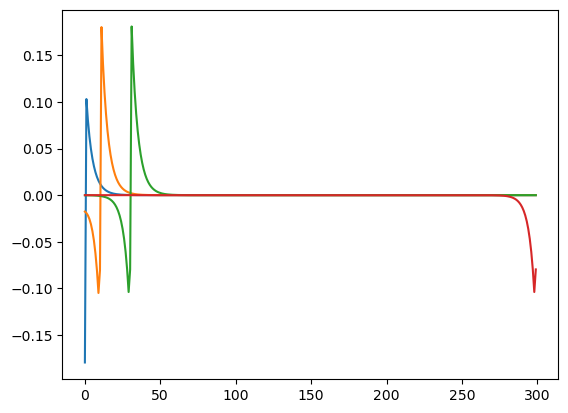

In [36]:
plt.plot(CJACR.T[0])
plt.plot(CJACR.T[10])
plt.plot(CJACR.T[30])
plt.plot(CJACR.T[-1])

plt.show()

In [11]:
CJACN, AJACN = Agent.calc_jacobian('labor', T)

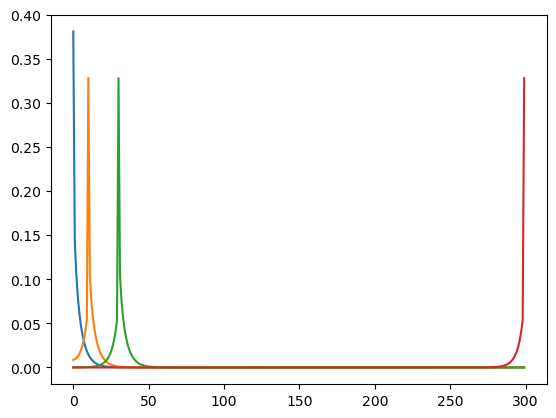

In [35]:
plt.plot(CJACN.T[0])
plt.plot(CJACN.T[10])
plt.plot(CJACN.T[30])
plt.plot(CJACN.T[-1])
plt.show()

In [13]:
@sj.simple
def ex_post_rate(r_ante):
    r = r_ante(-1)
    return r

@sj.simple
def Income(Y):
    Z = Y
    return Z

@sj.simple
def mkt_clearing_simple(A, B, Y, C):
    asset_mkt = A - B
    goods_mkt = C - Y
    return asset_mkt, goods_mkt

In [14]:
HARK_Jacobian_Dict = JacobianDict( { 'C' : {'r' : CJACR, 'Z': CJACN} ,'A' : {'r' : AJACR, 'Z': CJACN} } ) #r_ante

In [15]:
HARK_SteadyState_Dict = SteadyStateDict({"Y": Y_ss, "Z": Y_ss, "r_ante": r_ss, "r": r_ss, "C": C_ss, "A": A_ss, "B": B_ss, "asset_mkt":0.0})

In [16]:
HARK_SteadyState_Dict

<SteadyStateDict: ['Y', 'Z', 'r_ante', 'r', 'C', 'A', 'B', 'asset_mkt']>

In [17]:
HARK_Jacobian_Dict['C']['r']

array([[-1.79427841e-01, -1.79306090e-01, -1.36923872e-01, ...,
         6.66133815e-09,  6.66133815e-09,  6.66133815e-09],
       [ 1.03045050e-01, -1.39136140e-01, -1.49529671e-01, ...,
         1.55431223e-08,  1.55431223e-08,  1.55431223e-08],
       [ 8.02957101e-02,  1.33911959e-01, -1.15877625e-01, ...,
         2.44249065e-08,  2.44249065e-08,  2.44249065e-08],
       ...,
       [ 2.39808173e-07,  2.39808173e-07,  2.39808173e-07, ...,
        -7.96355581e-02, -1.03859077e-01, -7.94348010e-02],
       [ 2.39808173e-07,  2.39808173e-07,  2.39808173e-07, ...,
         1.80878059e-01, -7.96355581e-02, -1.03859077e-01],
       [ 2.39808173e-07,  2.39808173e-07,  2.39808173e-07, ...,
         1.41283230e-01,  1.80878059e-01, -7.96355581e-02]])

In [18]:
HARK_HANK = create_model([HARK_Jacobian_Dict, Income, ex_post_rate, mkt_clearing_simple], name="HARK_HANK")
unknowns = ['Y']
targets = ['asset_mkt']
exogenous = ['r_ante']

In [19]:
# Find the linear impulse responses to an "r" shock
dr = -0.01 * 0.7 ** np.arange(T)
shocks = {'r_ante': dr}    

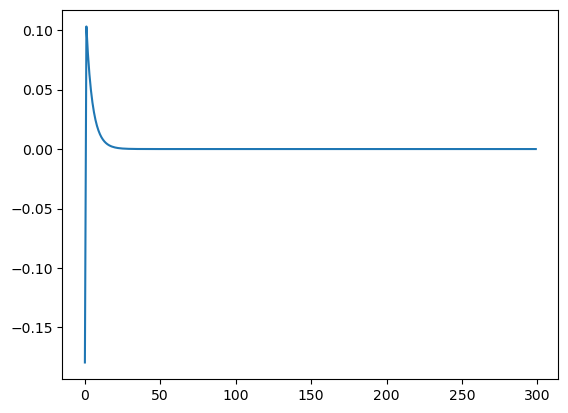

In [20]:
plt.plot(CJACR.T[0])
plt.show()

In [21]:
J_ex_post_rate = ex_post_rate.jacobian(HARK_SteadyState_Dict, inputs=['r_ante'])

In [22]:
J_ex_post_rate['r']['r_ante']

SimpleSparse({(-1, 0): 1.000})

In [23]:
irf = J_ex_post_rate['r']['r_ante'] @ HARK_Jacobian_Dict['C']['r']

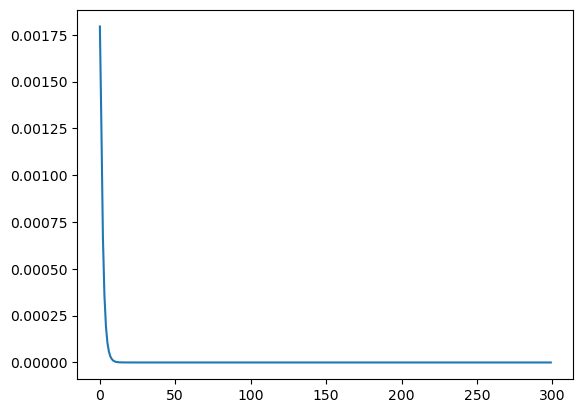

In [24]:
plt.plot(irf[1]*dr)
plt.show()

In [32]:
irf = HARK_HANK.solve_impulse_linear(HARK_SteadyState_Dict, ['Y'], ['asset_mkt'], shocks) #{'r_ante': dr})
# tutil.figure_1(irf, HARK_SteadyState_Dict, dr)

In [33]:
def show_irfs(irfs_list, variables, labels=[" "], ylabel=r"Percentage points (dev. from ss)", T_plot=50, figsize=(18, 6)):
    if len(irfs_list) != len(labels):
        labels = [" "] * len(irfs_list)
    n_var = len(variables)
    fig, ax = plt.subplots(1, n_var, figsize=figsize, sharex=True)
    for i in range(n_var):
        # plot all irfs
        for j, irf in enumerate(irfs_list):
            ax[i].plot(100 * irf[variables[i]][:50], label=labels[j])
        ax[i].set_title(variables[i])
        ax[i].set_xlabel(r"$t$")
        if i==0:
            ax[i].set_ylabel(ylabel)
        ax[i].legend()
    plt.show()

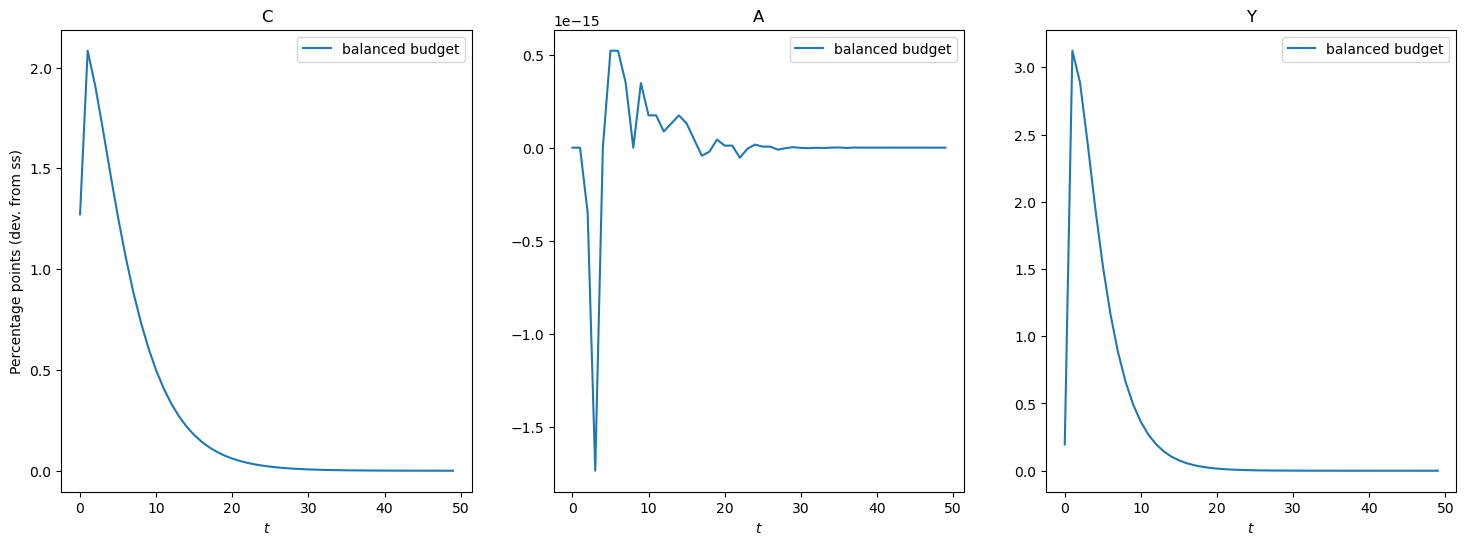

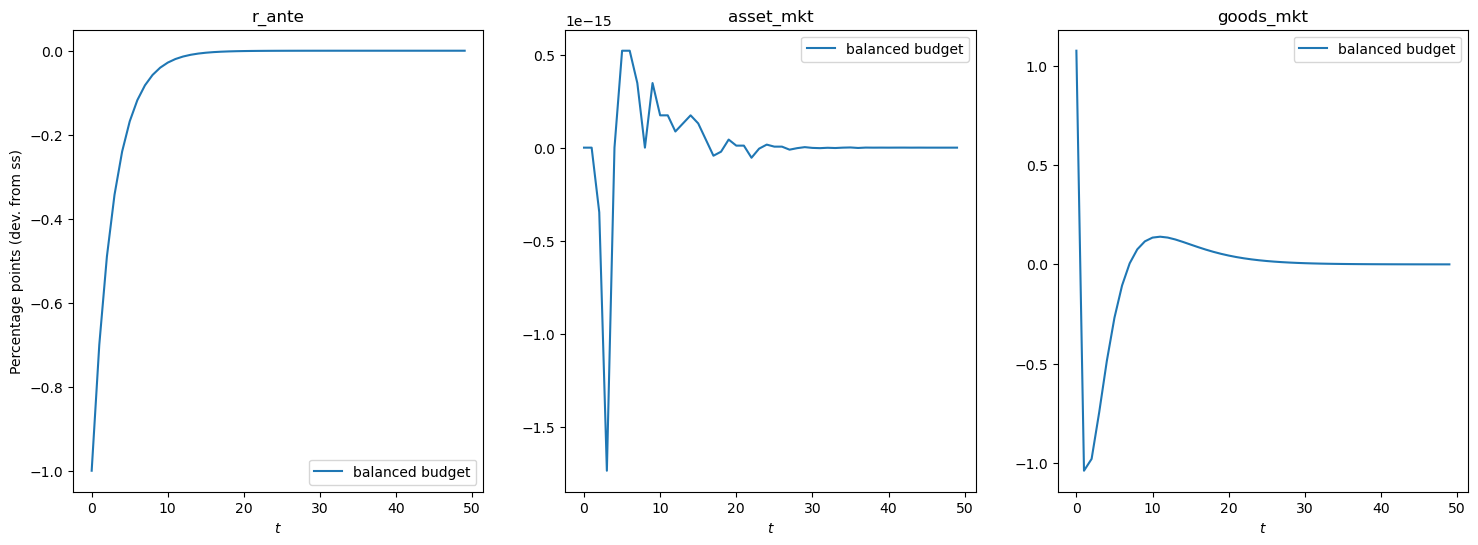

In [34]:
show_irfs([irf], ['C', 'A', 'Y'], labels=["balanced budget"])
show_irfs([irf], ['r_ante', 'asset_mkt', 'goods_mkt'], labels=["balanced budget"])

In [28]:
stop

NameError: name 'stop' is not defined

# Case 2: With Fiscal Policy

In [ ]:
@sj.simple
def fiscal(B, r, G, Y): 
    T = (1 + r) * B(-1) + G - B
    Z = Y - T
    
    deficit = G - T
    
    return T, Z, deficit

In [ ]:
def fiscal_ss(B, r, G): 
    T = (1 + r) * B + G - B
    
    return T

r_ss = 1.03 - 1
G_ss = 0
B_ss = 0.2 # this is lower than the tutorial by Straub et al. because need Higher MPC
A_ss = B_ss
Y_ss = 1.0
tau = 0.0

T_ss = fiscal_ss(B_ss,r_ss,G_ss)

print('T_ss: ' +str(T_ss))

Z_ss = Y_ss - T_ss

C_ss= Y_ss - G_ss
print('Z_ss: ' +str(Z_ss))

print('C_ss: ' +str(Y_ss - G_ss))

Dict['labor'] = [Z_ss]

## Steady State GE

In [ ]:
Asset_target = B_ss
DiscFac = optimize.brentq(ss_dif,.75,.99)
Dict['DiscFac'] = DiscFac

In [ ]:
DiscFac

In [ ]:
Agent_Case2 = IndShockConsumerType(**Dict, verbose = False)

In [ ]:
start = time.time()
Agent_Case2.compute_steady_state()
print('Seconds to compute steady state', time.time() - start)

In [ ]:
start = time.time()

CJACR_Case2, AJACR_Case2 = Agent_Case2.calc_jacobian('Rfree',T)
CJACN_Case2, AJACN_Case2 = Agent_Case2.calc_jacobian('labor',T)

print('Seconds to calculate Jacobian', time.time() - start)

In [ ]:
HARK_SteadyState_Dict_Case2 = SteadyStateDict({"G": 1.0, "asset_mkt":0.0, "C": C_ss, "r": r_ss, "Y": Y_ss, "B":B_ss, "G":G_ss, "A": A_ss,  "r_ante": r_ss })
HARK_Jacobian_Dict_Case2 = JacobianDict( { 'C' : {'r' : CJACR_Case2, 'Z' : CJACN_Case2} ,'A' : {'r' : AJACR_Case2, 'Z' : CJACR_Case2} } )

In [ ]:
HARK_HANK_Case2 = create_model([HARK_Jacobian_Dict, fiscal, ex_post_rate, mkt_clearing_simple], name="HARK_HANK")
unknowns = ['Y']
targets = ['asset_mkt']
exogenous = ['r_ante']

In [ ]:
irf_Case2 = HARK_HANK_Case2.solve_impulse_linear(HARK_SteadyState_Dict_Case2, ['Y'], ['asset_mkt'], shocks) #{'r_ante': dr})
#tutil.figure_1(irf_Case2, HARK_SteadyState_Dict_Case2, dr)

In [ ]:
irf_Case2

In [ ]:
def show_irfs(irfs_list, variables, labels=[" "], ylabel=r"Percentage points (dev. from ss)", T_plot=50, figsize=(18, 6)):
    if len(irfs_list) != len(labels):
        labels = [" "] * len(irfs_list)
    n_var = len(variables)
    fig, ax = plt.subplots(1, n_var, figsize=figsize, sharex=True)
    for i in range(n_var):
        # plot all irfs
        for j, irf in enumerate(irfs_list):
            ax[i].plot(100 * irf[variables[i]][:50], label=labels[j])
        ax[i].set_title(variables[i])
        ax[i].set_xlabel(r"$t$")
        if i==0:
            ax[i].set_ylabel(ylabel)
        ax[i].legend()
    plt.show()

In [ ]:
show_irfs([irf_Case2], ['r', 'Y', 'deficit'], labels=["balanced budget"])
show_irfs([irf_Case2], ['C', 'A', 'T'], labels=["balanced budget"])
show_irfs([irf_Case2], ['asset_mkt', 'goods_mkt'], labels=["balanced budget"])